<a href="https://colab.research.google.com/github/andrewwells991/wb_dime_application/blob/main/world_bank_dime_application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Python code featured below is part of that which is being used for a thesis for a master's degree in Data Science for Public Policy from the Hertie School. The thesis is titled, "Utilization of machine learning on satellite images to predict the economic development of previous World Bank project sites".

For this research, I am using geocoded data on World Bank projects available from AidData. This data features the project details and locations of World Bank projects from 1995 - 2014. I filtered this data for only projects in Malawi that should have a local impact, such as infrastructure projects. I then created a 4 sqaure kilometer region of interest (ROI) around the project points and extracted the building data from Google's Open Buildings project. Open Buildings mapped (most) buildings in Africa with their polygon coordinates through a deep learning model.

Through Google Earth Engine's API, I extracted the Sentinel-2 pixel data (band values and coordinates) from each region of interest for 2021. Two points of note: images from 2021 were chosen as this was the year that data for the Open Buildings project was taken; and band values are the way in which satellites extract data. I joined the pixels with the buildings with Geopandas based on if the pixel coordinate (point) fit inside of a building (polygon). This created a labelled dataset with pixels labelled building = 1 for that that were part of a building and building = 0 for those not part of a building.

The code below demonstrates how the labelled dataset was initially analyzed, then trained using various machine learning models. The models were then applied to satellite images from previous years (2015 - 2020) to estimate the growth in buildings at the project sites bewteen 2015 and 2020.


##Load libraries and data

In [ ]:
#Loading GeoPandas
!pip install geopandas

In [ ]:
!pip install geemap

In [2]:
#Mount to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Data Processing
import pandas as pd
import numpy as np
import geopandas as gpd

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

from shapely.geometry import Point, Polygon

In [4]:
#Labeled dataset (stored in Google Drive)
df = pd.read_csv('/content/gdrive/MyDrive/mds_thesis/5_labelled_data/proj_all.csv')

<ipython-input-4-fe6bd77d517b>:2: DtypeWarning: Columns (10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/gdrive/MyDrive/mds_thesis/5_labelled_data/proj_all.csv')


In [5]:
df.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'B2', 'B3', 'B4', 'B8',
       'B11', 'B12', 'row', 'geometry', 'index_right', 'latitude', 'longitude',
       'area_in_meters', 'confidence', 'full_plus_code', 'building', 'project',
       'building_sum', 'urban_rural', 'proj_name', 'start_date', 'end_dat',
       'total_commitment', 'total_disbursement', 'sectors', 'ieg_outcome',
       'place_name'],
      dtype='object')

In [6]:
#Drop unnecessary variable
df = df.drop(['Unnamed: 0.1', 'Unnamed: 0.2', 'Unnamed: 0'], axis=1)

In [8]:
#Examining size of dataset
df.shape

(2271428, 26)

##Visualizing pixels for project site (2021)

Project sites can be viewed based on entering the project code ('project') (example: proj_2_20) or the location ('place_name') (example: Mangochi). The pixels are demonstrated in black for those labelled as building = 1 and white for building = 0. 

['Road Maintenance and Rehabilitation Project']
[1786]
['urban']
['Nkhata Bay']


/usr/local/lib/python3.9/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

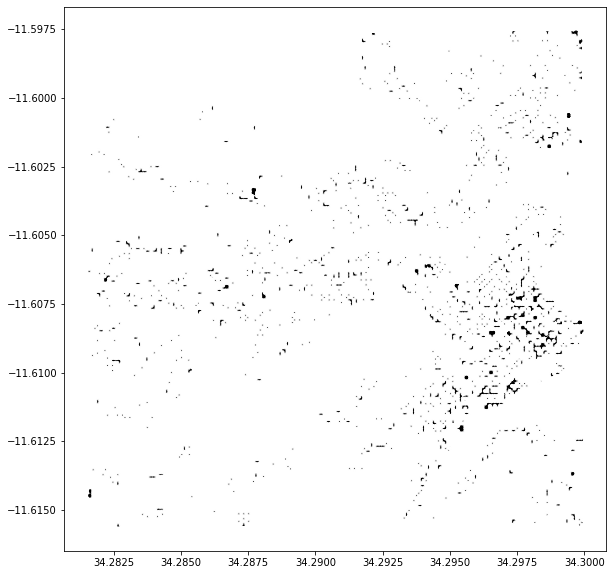

In [10]:
#Select project and site
proj = df[(df['project'] == 'proj_2_20')]
#proj = df[(df['place_name'] == 'Nkhata Bay')]

#View number of pixels in ROI classified as building and urban/rural classification
print(proj['proj_name'].values[:1])
print(proj['building_sum'].values[:1])
print(proj['urban_rural'].values[:1])
print(proj['place_name'].values[:1])

#Cleaning data
df_vis = proj.drop(['geometry', 'B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'row', 'index_right', 'area_in_meters', 'confidence', 'full_plus_code'], axis=1)

#Making GeoPandas
points = df_vis.apply(lambda row: Point(row.longitude, row.latitude), axis = 1)
gdf = gpd.GeoDataFrame(df, geometry=points)
gdf.crs = {'init': 'epsg:4326'}

# Create a new column to represent color based on Building value
gdf['color'] = ['black' if x == 1 else 'white' for x in gdf['building']]

# Plot the data
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax = ax, markersize=10, color = gdf['color'])

The satellite images along with the Open Buildings polygons overlay can be viewed to compare through the Google Earth Engine API.

In [13]:
#Earth Enging Initialization
import ee
import geemap
geemap.ee_initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=WUPH6OJGLzYoLp1EvhqYDax9jPcjJu3TDtigWrKK3sk&tc=kPhwcwwzSOLmrUnfpIV8t83NNu8fBT27J4aeywtSgig&cc=B1nwjbfz7Ai1-a3V6qCx9c8WgukmTd-wpjiTWe8NVdo

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AVHEtk5wRy6knkdQMNAqnFgui77e8RTOEdsIPVqkZzG9BkioZNZJ0mSmMbY

Successfully saved authorization token.


In [15]:
#Load satellite (Sentinel-2)
s2 = ee.ImageCollection('COPERNICUS/S2')

#Set ROI
#Must change based on location - Here for Nkhata Bay, same as above
roi = ee.Geometry.Polygon([
[[34.2815593682328, -11.59759], [34.2999006317672, -11.59759], [34.2999006317672, -11.61559], [34.2815593682328, -11.61559]]
])

#Image parameters
image = s2 \
  .filter(ee.Filter.date('2021-08-01', '2021-08-30')) \
  .sort("CLOUD_COVERAGE_ASSESSMENT") \
  .filter(ee.Filter.bounds(roi)) \
  .first() \
  .clip(roi)

#Incorporate Open Buildings into image
t = ee.FeatureCollection('GOOGLE/Research/open-buildings/v2/polygons')
t_building = t.filter('confidence >= 0.60')

Map = geemap.Map(center=(-11.60659, 34.29073), zoom = 15) #Change based on location
Map.addLayer(
    image,
    {"bands": ['B4', 'B3', 'B2'], "min": 0, "max": 3000},
    'image',
)

Map.addLayer(t_building, {'color': '000000'}, 'Open builidings')

Map #Note: the layers can be removed from view by clicking on the tool on the top right of the map, then the "layers" button, which appears to the left of the tool

Map(center=[-11.60659, 34.29073], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

##Examination of number and proportion of building pixels

In [ ]:
#Number of pixels part of building
sum(df['building'])

80757

In [ ]:
#Proportion of pixels which are buildings
sum(df['building'])/(len(df.index))

0.03555340517066797

Text(0, 0.5, 'Proportion')

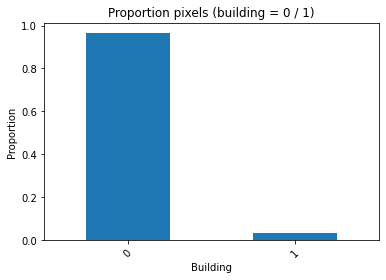

In [ ]:
#Graphical examination of class imbalance
value_counts = df['building'].value_counts(normalize = True)

# plot the result using a bar plot
value_counts.plot(kind='bar', title='Proportion pixels (building = 0 / 1)')
plt.xlabel('Building')
plt.xticks(rotation=45)
plt.ylabel('Proportion')

[Text(0, 0, 'Rural'), Text(1, 0, 'Semi-Urban'), Text(2, 0, 'Urban')]

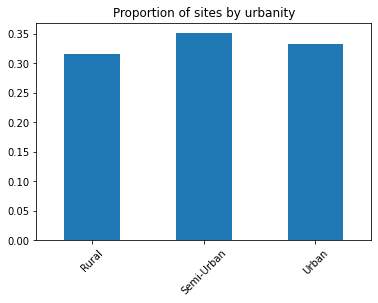

In [ ]:
#Graphical examination of urbanity
value_counts = df['urban_rural'].value_counts(normalize=True)
ordered_value_counts = value_counts.reindex(['rural', 'semi_urban', 'urban'])

#Plot the result using a bar plot
ordered_value_counts.plot(kind='bar', title='Proportion of sites by urbanity')
plt.xlabel('')
plt.xticks(rotation=45)
plt.ylabel('')

plt.gca().set_xticklabels(['Rural', 'Semi-Urban', 'Urban'])

[Text(0, 0, 'Rural'), Text(1, 0, 'Semi-Urban'), Text(2, 0, 'Urban')]

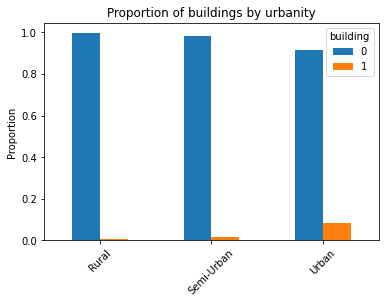

In [ ]:
#Group the data by the "project" column and count the number of occurrences of each value in the "building" column for each group
grouped_counts = df.groupby('urban_rural')['building'].value_counts(normalize=True)

#Plot the result using a stacked bar plot
grouped_counts.unstack().plot(kind='bar', title='Proportion of buildings by urbanity')
plt.xlabel('')
plt.xticks(rotation=45)
plt.ylabel('Proportion')

plt.gca().set_xticklabels(['Rural', 'Semi-Urban', 'Urban'])

Examining band values for buildings vs. not buildings

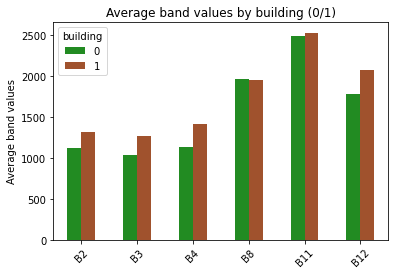

In [ ]:
df_bands = df[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'building']]

#Viewing band values grouped by building
df_plt = df_bands.groupby(by=['building']).mean()

df_plt = df_plt.T

colors = {0: 'forestgreen', 1: 'sienna'}
df_plt.plot(kind='bar', color=[colors[idx] for idx in df_plt.columns])
plt.title('Average band values by building (0/1)')
plt.ylabel('Average band values')
plt.xticks(rotation=45)
plt.show()

##Preparing data for machine leanrning

Splitting imbalanced data

In [ ]:
#Load library
from sklearn.model_selection import train_test_split

In [ ]:
#Setting variables
feature_names = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']
label = "building"

X = df[feature_names]
y = df[label]

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
#Combine training data for saving in Drive
df_train = pd.concat([X_train, y_train], axis=1)

#Combine test data for saving in Drive
df_test = pd.concat([X_test, y_test], axis=1)

Over-sampling data and splitting

total class of 1 and 0: 1    2190671
0    2190671
Name: building, dtype: int64


<Axes: title={'center': 'Count pixels (building = 0 / 1)'}>

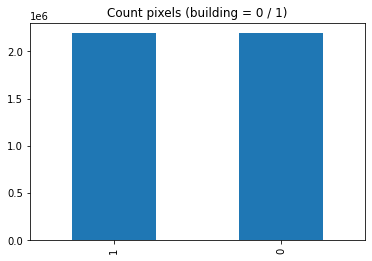

In [16]:
# class count
class_count_0, class_count_1 = df['building'].value_counts()

# Separate class
class_0 = df[df['building'] == 0]
class_1 = df[df['building'] == 1]# print the shape of the class

#Random Over Sampling
class_1_over = class_1.sample(class_count_0, replace=True)

df_over = pd.concat([class_1_over, class_0], axis=0)

print("total class of 1 and 0:",df_over['building'].value_counts())

#Count after under-sampeling
df_over['building'].value_counts().plot(kind='bar', title='Count pixels (building = 0 / 1)')

In [ ]:
X_over = df_over[feature_names]
y_over = df_over[label]

# Split the data into training and test sets
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size = 0.2, random_state = 42)

In [ ]:
#Combine training data
df_train_over = pd.concat([X_train_over, y_train_over], axis=1)

#Combine test data
df_test_over = pd.concat([X_test_over, y_test_over], axis=1)

Saving training and test sets to Drive

In [ ]:
#Saving imbalanced training data to Drive
path = '/content/gdrive/My Drive/mds_thesis/6_split_data/df_train.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:  
  df_train.to_csv(f)

#Saving imbalanced test data to Drive
path = '/content/gdrive/My Drive/mds_thesis/6_split_data/df_test.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:  
  df_test.to_csv(f)

#Saving over-sampled training data to Drive
path = '/content/gdrive/My Drive/mds_thesis/6_split_data/df_train_over.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:  
  df_train_over.to_csv(f)

#Saving over-sampled test data to Drive
path = '/content/gdrive/My Drive/mds_thesis/6_split_data/df_test_over.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:  
  df_test_over.to_csv(f)

##Training ML models

In [17]:
#Loading libraries
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_validate, StratifiedKFold
from scipy.stats import randint
from pprint import pprint

Load data from Drive. Model were already trained and saved in Drive (through library pickle), so they are not run again - just here for code demonstration.

In [19]:
#Loaing imbalanced data from Drive
df_train = pd.read_csv('/content/gdrive/MyDrive/mds_thesis/6_split_data/df_train.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/mds_thesis/6_split_data/df_test.csv')

df_train2 = df_train[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude', 'building']]
df_test2 = df_test[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude', 'building']]

#Convert from pandas to numpy array
train_np = df_train2.to_numpy()
X_train, y_train = train_np[:, :-1], train_np[:, -1]

test_np = df_test2.to_numpy()
X_test, y_test = test_np[:, :-1], test_np[:, -1]

#Load over-sampled data from Drive
df_train_over = pd.read_csv('/content/gdrive/MyDrive/mds_thesis/6_split_data/df_train_over.csv')
df_test_over = pd.read_csv('/content/gdrive/MyDrive/mds_thesis/6_split_data/df_test_over.csv')

df_train_over2 = df_train_over[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude', 'building']]
df_test_over2 = df_test_over[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude', 'building']]

#Convert from pandas to numpy arrays
train_over_np = df_train_over2.to_numpy()
X_train_over, y_train_over = train_over_np[:, :-1], train_over_np[:, -1]

test_over_np = df_test_over2.to_numpy()
X_test_over, y_test_over = test_over_np[:, :-1], test_over_np[:, -1]

#Set X_train variables (used for graphing feature importance)
X_train = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']

In [ ]:
#Random forest (imbalanced data)
rf_std = RandomForestClassifier(random_state = 42)
rf_std.fit(X_train, y_train)

#Random forest (imbalanced data - weighted)
rf_wgt = RandomForestClassifier(class_weight = 'balanced', random_state = 42)
rf_wgt.fit(X_train, y_train)

#XGBoost (imbalanced data)
xgb_std = XGBClassifier(random_state = 42)
xgb_std.fit(X_train, y_train)

#KNN (imbalanced data)
knn_std = neighbors.KNeighborsClassifier()
knn_std.fit(X_train, y_train)

###Save models to Drive

In [23]:
import pickle

In [ ]:
#rf_std
with open('rf_std', 'wb') as f:
  pickle.dump(rf_std, f)

#xgb_std
with open('xgb_std', 'wb') as f:
  pickle.dump(rf_std, f)

#rf_wgt
with open('rf_wgt', 'wb') as f:
  pickle.dump(rf_wgt, f)

#knn_std
with open('knn_std', 'wb') as f:
  pickle.dump(knn_std, f)

#xgb_over
with open('xgb_over', 'wb') as f:
  pickle.dump(xgb_over, f)

#rf_over
with open('rf_over', 'wb') as f:
  pickle.dump(rf_over, f)

##Model evaluations

In [18]:
#Loading libraries
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [24]:
#Loading models, which were saved on Drive with pickle library
rf_std = pickle.load(open('/content/gdrive/MyDrive/mds_thesis/8_saved_models/rf_std', 'rb'))
rf_wgt = pickle.load(open('/content/gdrive/MyDrive/mds_thesis/8_saved_models/rf_wgt', 'rb'))
xgb_std = pickle.load(open('/content/gdrive/MyDrive/mds_thesis/8_saved_models/xgb_std', 'rb'))
knn_std = pickle.load(open('/content/gdrive/MyDrive/mds_thesis/8_saved_models/knn_std', 'rb'))
rf_over = pickle.load(open('/content/gdrive/MyDrive/mds_thesis/8_saved_models/rf_over', 'rb'))
xgb_over = pickle.load(open('/content/gdrive/MyDrive/mds_thesis/8_saved_models/xgb_over', 'rb'))

In [20]:
#Set testing data
X_test = df_test.drop(['Unnamed: 0', 'building'], axis = 1)
y_test = df_test['building']

X_test_over = df_test_over.drop(['Unnamed: 0', 'building'], axis = 1)
y_test_over = df_test_over['building']

###Evaluation of imbalanced data models

Random forest evaluation

In [25]:
#Evaluate
y_pred_rf_std = rf_std.predict(X_test)
print(classification_report(y_test, y_pred_rf_std))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    438023
           1       0.85      0.35      0.49     16263

    accuracy                           0.97    454286
   macro avg       0.91      0.67      0.74    454286
weighted avg       0.97      0.97      0.97    454286



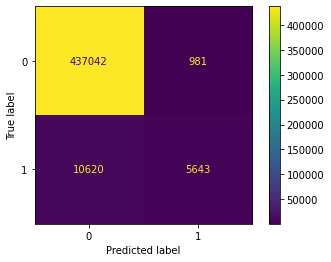

In [27]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf_std)
ConfusionMatrixDisplay(confusion_matrix = cm).plot()

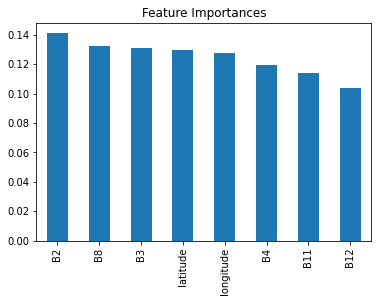

In [29]:
#Feature importances
feature_importances = pd.Series(rf_std.feature_importances_, index = X_test.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importances')
plt.show()

Random forest (weighted) evaluation

In [30]:
#Evaluate
y_pred_rf_wgt = rf_wgt.predict(X_test)
print(classification_report(y_test, y_pred_rf_wgt))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    438023
           1       0.90      0.32      0.47     16263

    accuracy                           0.97    454286
   macro avg       0.94      0.66      0.73    454286
weighted avg       0.97      0.97      0.97    454286



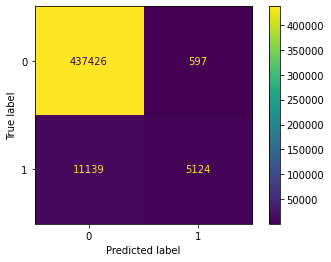

In [31]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf_wgt)
ConfusionMatrixDisplay(confusion_matrix = cm).plot()

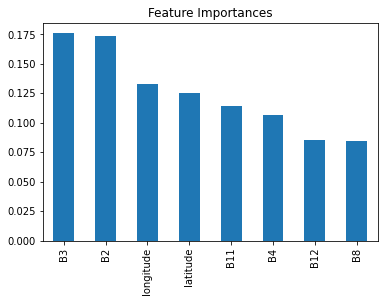

In [32]:
#Feature importances
feature_importances = pd.Series(rf_wgt.feature_importances_, index = X_test.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importances')
plt.show()

XGBoost evaluation

In [33]:
#Evaluate
y_pred_xgb_std = xgb_std.predict(X_test)
print(classification_report(y_test, y_pred_xgb_std))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    438023
           1       0.85      0.35      0.49     16263

    accuracy                           0.97    454286
   macro avg       0.91      0.67      0.74    454286
weighted avg       0.97      0.97      0.97    454286



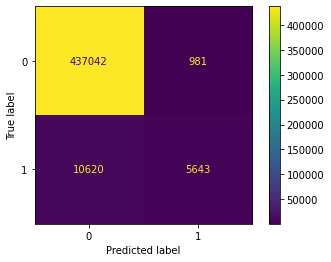

In [34]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb_std)
ConfusionMatrixDisplay(confusion_matrix = cm).plot()

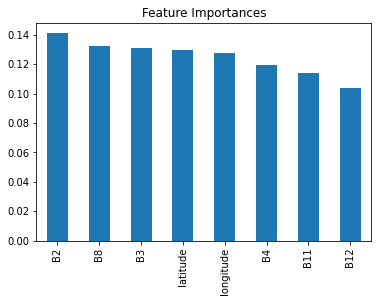

In [35]:
#Feature importances
feature_importances = pd.Series(xgb_std.feature_importances_, index = X_test.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importances')
plt.show()

KNN Evaluation

In [36]:
#Evaluate
y_pred_knn_std = knn_std.predict(X_test)
print(classification_report(y_test, y_pred_knn_std))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    438023
           1       0.46      0.18      0.26     16263

    accuracy                           0.96    454286
   macro avg       0.72      0.59      0.62    454286
weighted avg       0.95      0.96      0.96    454286



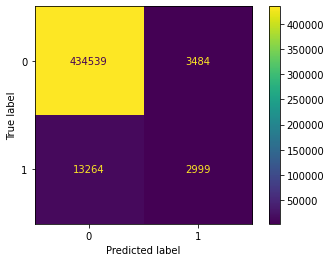

In [37]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred_knn_std)
ConfusionMatrixDisplay(confusion_matrix = cm).plot()

###Evaluation of over-sampled data models

Random forest (over-sampled)

In [38]:
#Evaluate
y_pred_rf_over = rf_over.predict(X_test_over)
print(classification_report(y_test_over, y_pred_rf_over))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    438751
           1       0.99      1.00      1.00    437518

    accuracy                           1.00    876269
   macro avg       1.00      1.00      1.00    876269
weighted avg       1.00      1.00      1.00    876269



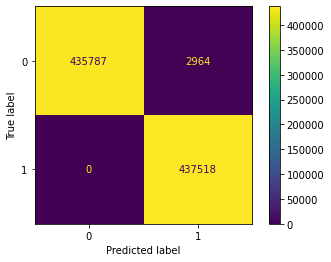

In [39]:
#Confusion matrix
cm = confusion_matrix(y_test_over, y_pred_rf_over)
ConfusionMatrixDisplay(confusion_matrix = cm).plot()

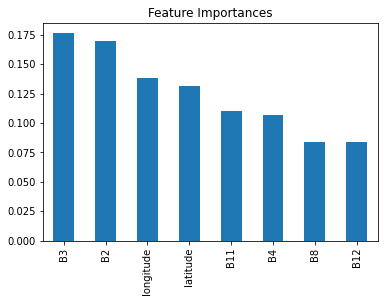

In [40]:
#Feature importances
feature_importances = pd.Series(rf_over.feature_importances_, index = X_test_over.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importances')
plt.show()

XGBoost (over-sampled

In [41]:
#Evaluate
y_pred_xgb_over = xgb_over.predict(X_test_over)
print(classification_report(y_test_over, y_pred_xgb_over))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88    438751
           1       0.86      0.92      0.89    437518

    accuracy                           0.88    876269
   macro avg       0.88      0.88      0.88    876269
weighted avg       0.88      0.88      0.88    876269



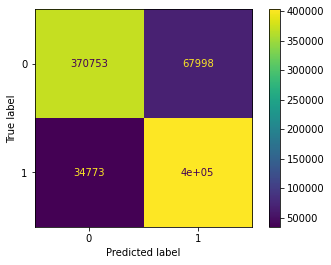

In [42]:
#Confusion matrix
cm = confusion_matrix(y_test_over, y_pred_xgb_over)
ConfusionMatrixDisplay(confusion_matrix = cm).plot()

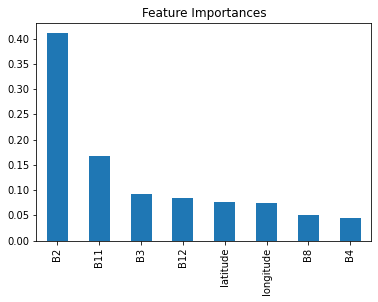

In [43]:
#Feature importances
feature_importances = pd.Series(xgb_over.feature_importances_, index = X_test_over.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importances')
plt.show()

###ROC-AUC Analysis

Imbalanced data models

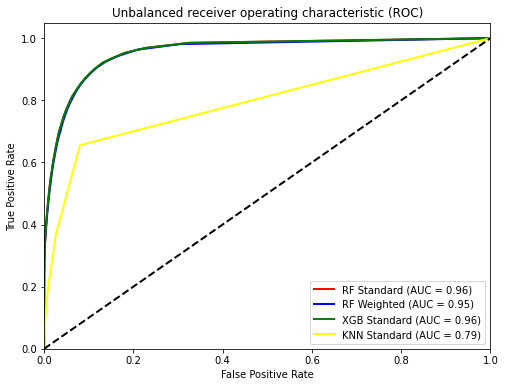

In [44]:
# rf_std
fpr_rf_std, tpr_rf_std, _ = roc_curve(y_test, rf_std.predict_proba(X_test)[:,1])
roc_auc_rf_std = auc(fpr_rf_std, tpr_rf_std)
# rf_wgt
fpr_rf_wgt, tpr_rf_wgt, _ = roc_curve(y_test, rf_wgt.predict_proba(X_test)[:,1])
roc_auc_rf_wgt = auc(fpr_rf_wgt, tpr_rf_wgt)
# xgb_std
fpr_xgb_std, tpr_xgb_std, _ = roc_curve(y_test, xgb_std.predict_proba(X_test)[:,1])
roc_auc_xgb_std = auc(fpr_xgb_std, tpr_xgb_std)
# knn_std
fpr_knn_std, tpr_knn_std, _ = roc_curve(y_test, knn_std.predict_proba(X_test)[:,1])
roc_auc_knn_std = auc(fpr_knn_std, tpr_knn_std)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf_std, tpr_rf_std, color='red', lw=2, label='RF Standard (AUC = %0.2f)' % roc_auc_rf_std)
plt.plot(fpr_rf_wgt, tpr_rf_wgt, color='blue', lw=2, label='RF Weighted (AUC = %0.2f)' % roc_auc_rf_wgt)
plt.plot(fpr_xgb_std, tpr_xgb_std, color='green', lw=2, label='XGB Standard (AUC = %0.2f)' % roc_auc_xgb_std)
plt.plot(fpr_knn_std, tpr_knn_std, color='yellow', lw=2, label='KNN Standard (AUC = %0.2f)' % roc_auc_knn_std)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Unbalanced receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Over-sampled data models

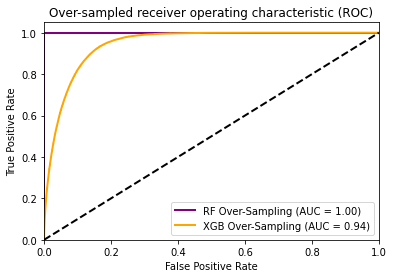

In [45]:
# rf_over
fpr_rf_over, tpr_rf_over, _ = roc_curve(y_test_over, rf_over.predict_proba(X_test_over)[:,1])
roc_auc_rf_over = auc(fpr_rf_over, tpr_rf_over)
# xgb_over
fpr_xgb_over, tpr_xgb_over, _ = roc_curve(y_test_over, xgb_over.predict_proba(X_test_over)[:,1])
roc_auc_xgb_over = auc(fpr_xgb_over, tpr_xgb_over)

plt.plot(fpr_rf_over, tpr_rf_over, color='purple', lw=2, label='RF Over-Sampling (AUC = %0.2f)' % roc_auc_rf_over)
plt.plot(fpr_xgb_over, tpr_xgb_over, color='orange', lw=2, label='XGB Over-Sampling (AUC = %0.2f)' % roc_auc_xgb_over)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Over-sampled receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

##Application of ML models on pixel data from previous years

Pixel data from the satellite images of the project sites was downloaded from the Google Earth Engine API. The datasets are stored in a GitHub repository. 

###Project 2_5, Project: Road Maintenance and Rehabilitation Project | Site: Mangochi


Loading data

In [46]:
#Unlabelled pixel data from 2021
proj_2_5_21 = pd.read_csv('https://raw.githubusercontent.com/andrewwells991/mds_thesis/main/data/2_ee_pixel_data/malawi_proj_2_5_yr_21_pixel.csv')
proj_2_5_21 = proj_2_5_21[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']]
#From previous years
proj_2_5_20 = pd.read_csv('https://raw.githubusercontent.com/andrewwells991/mds_thesis/main/data/4_ee_pixel_data_other_yrs/malawi_proj_2_5_yr_20_pixel.csv')
proj_2_5_20 = proj_2_5_20[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']]
proj_2_5_19 = pd.read_csv('https://raw.githubusercontent.com/andrewwells991/mds_thesis/main/data/4_ee_pixel_data_other_yrs/malawi_proj_2_5_yr_19_pixel.csv')
proj_2_5_19 = proj_2_5_19[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']]
proj_2_5_18 = pd.read_csv('https://raw.githubusercontent.com/andrewwells991/mds_thesis/main/data/4_ee_pixel_data_other_yrs/malawi_proj_2_5_yr_18_pixel.csv')
proj_2_5_18 = proj_2_5_18[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']]
proj_2_5_17 = pd.read_csv('https://raw.githubusercontent.com/andrewwells991/mds_thesis/main/data/4_ee_pixel_data_other_yrs/malawi_proj_2_5_yr_17_pixel.csv')
proj_2_5_17 = proj_2_5_17[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']]
proj_2_5_16 = pd.read_csv('https://raw.githubusercontent.com/andrewwells991/mds_thesis/main/data/4_ee_pixel_data_other_yrs/malawi_proj_2_5_yr_16_pixel.csv')
proj_2_5_16 = proj_2_5_16[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']]
proj_2_5_15 = pd.read_csv('https://raw.githubusercontent.com/andrewwells991/mds_thesis/main/data/4_ee_pixel_data_other_yrs/malawi_proj_2_5_yr_15_pixel.csv')
proj_2_5_15 = proj_2_5_15[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']]

Create a dataset of the predicted number of buildings at the site for each year, by model

In [47]:
proj_2_5_predictions = pd.DataFrame(columns=['rf_std', 'rf_wgt', 'xgb_std', 'knn_std', 'rf_over', 'xgb_over', 'year'])

for df_name in ['proj_2_5_15', 'proj_2_5_16', 'proj_2_5_17', 'proj_2_5_18', 'proj_2_5_19', 'proj_2_5_20', 'proj_2_5_21']:
    df = globals()[df_name]
    
    rf_std_pred = rf_std.predict(df)
    rf_wgt_pred = rf_wgt.predict(df)
    xgb_std_pred = xgb_std.predict(df)
    knn_std_pred = knn_std.predict(df)
    rf_over_pred = rf_over.predict(df)
    xgb_over_pred = xgb_over.predict(df)

    predictions_df = pd.DataFrame({
        'rf_std': rf_std_pred,
        'rf_wgt': rf_wgt_pred,
        'xgb_std': xgb_std_pred,
        'knn_std': knn_std_pred,
        'rf_over': rf_over_pred,
        'xgb_over': xgb_over_pred
    })

    rf_std_sum = predictions_df['rf_std'].sum()
    rf_wgt_sum = predictions_df['rf_wgt'].sum()
    xgb_std_sum = predictions_df['xgb_std'].sum()
    knn_std_sum = predictions_df['knn_std'].sum()
    rf_over_sum = predictions_df['rf_over'].sum()
    xgb_over_sum = predictions_df['xgb_over'].sum()

    year = int(df_name[-2:]) + 2000
    row = {
        'rf_std': rf_std_sum,
        'rf_wgt': rf_wgt_sum,
        'xgb_std': xgb_std_sum,
        'knn_std': knn_std_sum,
        'rf_over': rf_over_sum,
        'xgb_over': xgb_over_sum,
        'year': year
    }

    proj_2_5_predictions = proj_2_5_predictions.append(row, ignore_index=True, sort=False)

Plotting results

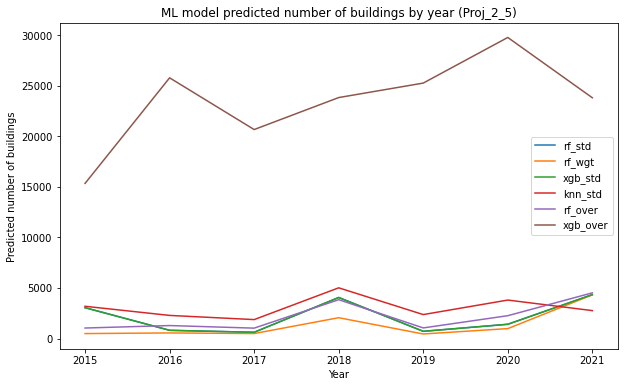

In [48]:
#Set year column as index
proj_2_5_predictions.set_index('year', inplace=True)

#Plot the predicted values by year for each of the models
proj_2_5_predictions.plot(kind='line', figsize=(10, 6))

#Set chart title and axis labels
plt.title('ML model predicted number of buildings by year (Proj_2_5)')
plt.xlabel('Year')
plt.ylabel('Predicted number of buildings')
plt.show()

###Project 2_6, Project: Road Maintenance and Rehabilitation Project | Site: Salima District

In [49]:
#Unlabelled pixel data from 2021
proj_2_6_21 = pd.read_csv('https://raw.githubusercontent.com/andrewwells991/mds_thesis/main/data/2_ee_pixel_data/malawi_proj_2_6_yr_21_pixel.csv')
proj_2_6_21 = proj_2_6_21[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']]
#From previous years
proj_2_6_20 = pd.read_csv('https://raw.githubusercontent.com/andrewwells991/mds_thesis/main/data/4_ee_pixel_data_other_yrs/malawi_proj_2_6_yr_20_pixel.csv')
proj_2_6_20 = proj_2_6_20[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']]
proj_2_6_19 = pd.read_csv('https://raw.githubusercontent.com/andrewwells991/mds_thesis/main/data/4_ee_pixel_data_other_yrs/malawi_proj_2_6_yr_19_pixel.csv')
proj_2_6_19 = proj_2_6_19[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']]
proj_2_6_18 = pd.read_csv('https://raw.githubusercontent.com/andrewwells991/mds_thesis/main/data/4_ee_pixel_data_other_yrs/malawi_proj_2_6_yr_18_pixel.csv')
proj_2_6_18 = proj_2_6_18[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']]
proj_2_6_17 = pd.read_csv('https://raw.githubusercontent.com/andrewwells991/mds_thesis/main/data/4_ee_pixel_data_other_yrs/malawi_proj_2_6_yr_17_pixel.csv')
proj_2_6_17 = proj_2_6_17[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']]
proj_2_6_16 = pd.read_csv('https://raw.githubusercontent.com/andrewwells991/mds_thesis/main/data/4_ee_pixel_data_other_yrs/malawi_proj_2_6_yr_16_pixel.csv')
proj_2_6_16 = proj_2_6_16[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']]
proj_2_6_15 = pd.read_csv('https://raw.githubusercontent.com/andrewwells991/mds_thesis/main/data/4_ee_pixel_data_other_yrs/malawi_proj_2_6_yr_15_pixel.csv')
proj_2_6_15 = proj_2_6_15[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']]

In [50]:
proj_2_6_predictions = pd.DataFrame(columns=['rf_std', 'rf_wgt', 'xgb_std', 'knn_std', 'rf_over', 'xgb_over', 'year'])

for df_name in ['proj_2_6_15', 'proj_2_6_16', 'proj_2_6_17', 'proj_2_6_18', 'proj_2_6_19', 'proj_2_6_20', 'proj_2_6_21']:
    df = globals()[df_name]
    
    rf_std_pred = rf_std.predict(df)
    rf_wgt_pred = rf_wgt.predict(df)
    xgb_std_pred = xgb_std.predict(df)
    knn_std_pred = knn_std.predict(df)
    rf_over_pred = rf_over.predict(df)
    xgb_over_pred = xgb_over.predict(df)

    predictions_df = pd.DataFrame({
        'rf_std': rf_std_pred,
        'rf_wgt': rf_wgt_pred,
        'xgb_std': xgb_std_pred,
        'knn_std': knn_std_pred,
        'rf_over': rf_over_pred,
        'xgb_over': xgb_over_pred
    })

    rf_std_sum = predictions_df['rf_std'].sum()
    rf_wgt_sum = predictions_df['rf_wgt'].sum()
    xgb_std_sum = predictions_df['xgb_std'].sum()
    knn_std_sum = predictions_df['knn_std'].sum()
    rf_over_sum = predictions_df['rf_over'].sum()
    xgb_over_sum = predictions_df['xgb_over'].sum()

    year = int(df_name[-2:]) + 2000
    row = {
        'rf_std': rf_std_sum,
        'rf_wgt': rf_wgt_sum,
        'xgb_std': xgb_std_sum,
        'knn_std': knn_std_sum,
        'rf_over': rf_over_sum,
        'xgb_over': xgb_over_sum,
        'year': year
    }

    proj_2_6_predictions = proj_2_6_predictions.append(row, ignore_index=True, sort=False)

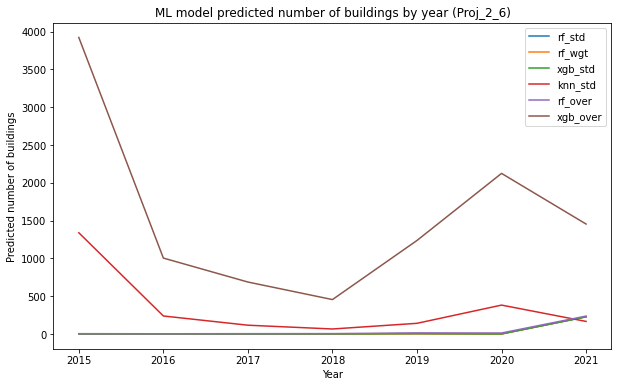

In [51]:
proj_2_6_predictions.set_index('year', inplace=True)

proj_2_6_predictions.plot(kind='line', figsize=(10, 6))

plt.title('ML model predicted number of buildings by year (Proj_2_6)')
plt.xlabel('Year')
plt.ylabel('Predicted number of buildings')
plt.show()

###Project 2_10, Project: Road Maintenance and Rehabilitation Project | Site: Zomba

In [53]:
#Unlabelled pixel data from 2021
proj_2_10_21 = pd.read_csv('https://raw.githubusercontent.com/andrewwells991/mds_thesis/main/data/2_ee_pixel_data/malawi_proj_2_10_yr_21_pixel.csv')
proj_2_10_21 = proj_2_10_21[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']]
#From previous years
proj_2_10_20 = pd.read_csv('https://raw.githubusercontent.com/andrewwells991/mds_thesis/main/data/4_ee_pixel_data_other_yrs/malawi_proj_2_10_yr_20_pixel.csv')
proj_2_10_20 = proj_2_10_20[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']]
proj_2_10_19 = pd.read_csv('https://raw.githubusercontent.com/andrewwells991/mds_thesis/main/data/4_ee_pixel_data_other_yrs/malawi_proj_2_10_yr_19_pixel.csv')
proj_2_10_19 = proj_2_10_19[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']]
proj_2_10_18 = pd.read_csv('https://raw.githubusercontent.com/andrewwells991/mds_thesis/main/data/4_ee_pixel_data_other_yrs/malawi_proj_2_10_yr_18_pixel.csv')
proj_2_10_18 = proj_2_10_18[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']]
proj_2_10_17 = pd.read_csv('https://raw.githubusercontent.com/andrewwells991/mds_thesis/main/data/4_ee_pixel_data_other_yrs/malawi_proj_2_10_yr_17_pixel.csv')
proj_2_10_17 = proj_2_10_17[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']]
proj_2_10_16 = pd.read_csv('https://raw.githubusercontent.com/andrewwells991/mds_thesis/main/data/4_ee_pixel_data_other_yrs/malawi_proj_2_10_yr_16_pixel.csv')
proj_2_10_16 = proj_2_10_16[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']]
proj_2_10_15 = pd.read_csv('https://raw.githubusercontent.com/andrewwells991/mds_thesis/main/data/4_ee_pixel_data_other_yrs/malawi_proj_2_10_yr_15_pixel.csv')
proj_2_10_15 = proj_2_10_15[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'longitude', 'latitude']]

In [56]:
proj_2_10_predictions = pd.DataFrame(columns=['rf_std', 'rf_wgt', 'xgb_std', 'knn_std', 'rf_over', 'xgb_over', 'year'])

for df_name in ['proj_2_10_15', 'proj_2_10_16', 'proj_2_10_17', 'proj_2_10_18', 'proj_2_10_19', 'proj_2_10_20', 'proj_2_10_21']:
    df = globals()[df_name]
    
    rf_std_pred = rf_std.predict(df)
    rf_wgt_pred = rf_wgt.predict(df)
    xgb_std_pred = xgb_std.predict(df)
    knn_std_pred = knn_std.predict(df)
    rf_over_pred = rf_over.predict(df)
    xgb_over_pred = xgb_over.predict(df)

    predictions_df = pd.DataFrame({
        'rf_std': rf_std_pred,
        'rf_wgt': rf_wgt_pred,
        'xgb_std': xgb_std_pred,
        'knn_std': knn_std_pred,
        'rf_over': rf_over_pred,
        'xgb_over': xgb_over_pred
    })

    rf_std_sum = predictions_df['rf_std'].sum()
    rf_wgt_sum = predictions_df['rf_wgt'].sum()
    xgb_std_sum = predictions_df['xgb_std'].sum()
    knn_std_sum = predictions_df['knn_std'].sum()
    rf_over_sum = predictions_df['rf_over'].sum()
    xgb_over_sum = predictions_df['xgb_over'].sum()

    year = int(df_name[-2:]) + 2000
    row = {
        'rf_std': rf_std_sum,
        'rf_wgt': rf_wgt_sum,
        'xgb_std': xgb_std_sum,
        'knn_std': knn_std_sum,
        'rf_over': rf_over_sum,
        'xgb_over': xgb_over_sum,
        'year': year
    }

    proj_2_10_predictions = proj_2_10_predictions.append(row, ignore_index=True, sort=False)

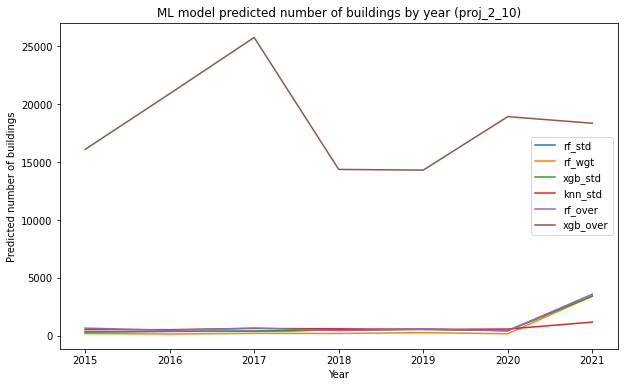

In [57]:
proj_2_10_predictions.set_index('year', inplace=True)
proj_2_10_predictions.plot(kind='line', figsize=(10, 6))
plt.title('ML model predicted number of buildings by year (proj_2_10)')
plt.xlabel('Year')
plt.ylabel('Predicted number of buildings')
plt.show()